## The aim is to test the dt response after several perturbations on the theta parameters against the real dt response

In [24]:
import itertools
import numpy as np
from src.digital_twin.bess import BatteryEnergyStorageSystem
from src.online_learning.optimizer import Optimizer
from src.online_learning.utils import utils
import pandas as pd
import os
import matplotlib.pyplot as plt

In [25]:
relative_path_ground = os.path.join('..', '..', 'src', 'online_learning', 'initialization', 'ground_pv.csv')
path_ground = utils.get_absolute_path(relative_path_ground)

# Load Dataframe
df = pd.read_csv(path_ground)
    
v_real = df['voltage'].values
i_real = df['current'].values
t_real = df['temperature'].values
time = df['time']
    
# Load YAML:
relative_path_grid = os.path.join('..','..','src','online_learning','initialization','grid_parameters')
path_grid = utils.get_absolute_path(relative_path_grid)
grid_parameters = utils.load_from_yaml(path_grid)
    
relative_path_electrical_params = os.path.join('..','..','src','online_learning',
                                                           'initialization','electrical_params')
path_electrical_params = utils.get_absolute_path(relative_path_electrical_params)
electrical_params = utils.load_from_yaml(path_electrical_params)
    
relative_path_thermal_params = os.path.join('..', '..', 'src', 'online_learning',
                                                           'initialization', 'thermal_params')
path_thermal_params = utils.get_absolute_path(relative_path_thermal_params)
    
thermal_params = utils.load_from_yaml(path_thermal_params)
models_config = [electrical_params, thermal_params]
    
relative_path_battery_options = os.path.join('..', '..', 'src', 'online_learning',
                                                        'initialization', 'battery_options')
path_battery_options = utils.get_absolute_path(relative_path_battery_options)
    
battery_options = utils.load_from_yaml(path_battery_options)
    
load_var = 'current'

In [26]:
battery = BatteryEnergyStorageSystem(
            models_config=models_config,
            battery_options=battery_options,
            input_var=load_var
            )

reset_info = {'electricala_params': electrical_params, 'thermal_params': thermal_params}
battery.reset(reset_info)
    
battery.init({'dissipated_heat' : 0 }) # check if you can remove it

elapsed_time = 0
dt = 1    

<Axes: >

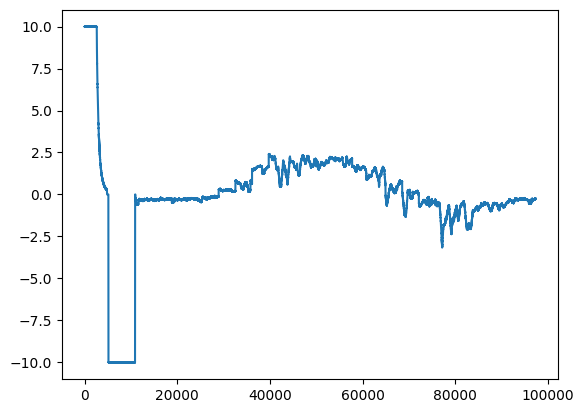

In [27]:
df['current'].plot()

In [28]:
for k, load in enumerate(i_real):
    elapsed_time += dt
    battery.t_series.append(elapsed_time)
    dt = df['time'].iloc[k] - df['time'].iloc[k - 1] if k > 0 else 1.0
    battery.step(load, dt, k)

In [29]:
baseline_results = battery.build_results_table()
baseline_voltage = baseline_results['operations']['voltage']
baseline_temperature = baseline_results['operations']['temperature']
baseline_time_series = battery.t_series.copy()

In [30]:
r0 = battery._electrical_model.r0.resistance
rc = battery._electrical_model.rc.resistance
c = battery._electrical_model.rc.capacity
theta_to_get = {'r0':r0,'rc':rc,'c':c}
print("theta_dt:",theta_to_get)

theta_dt: {'r0': 0.04, 'rc': 0.01, 'c': 10000.0}


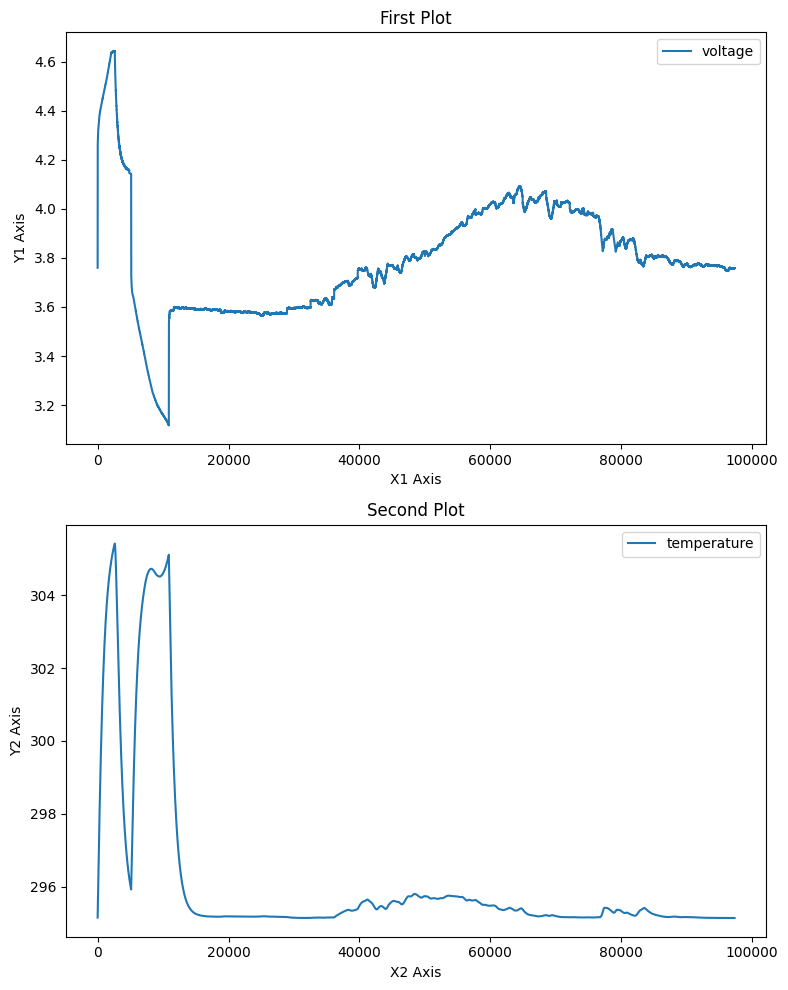

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# First subplot
ax1.plot(baseline_voltage, label='voltage')
ax1.set_xlabel('X1 Axis')
ax1.set_ylabel('Y1 Axis')
ax1.set_title('First Plot')
ax1.legend()

# Second subplot
ax2.plot(baseline_temperature, label='temperature')
ax2.set_xlabel('X2 Axis')
ax2.set_ylabel('Y2 Axis')
ax2.set_title('Second Plot')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

## test theta exploding

In [36]:
def set_battery(battery, reset_info, theta):
    battery.reset()
    battery.init(reset_info)
    battery._electrical_model.r0.resistance = theta[0]   
    battery._electrical_model.rc.resistance = theta[1]
    battery._electrical_model.rc.capacity = theta[2]

r0: 0.058, rc: 0.4, c: 72

72


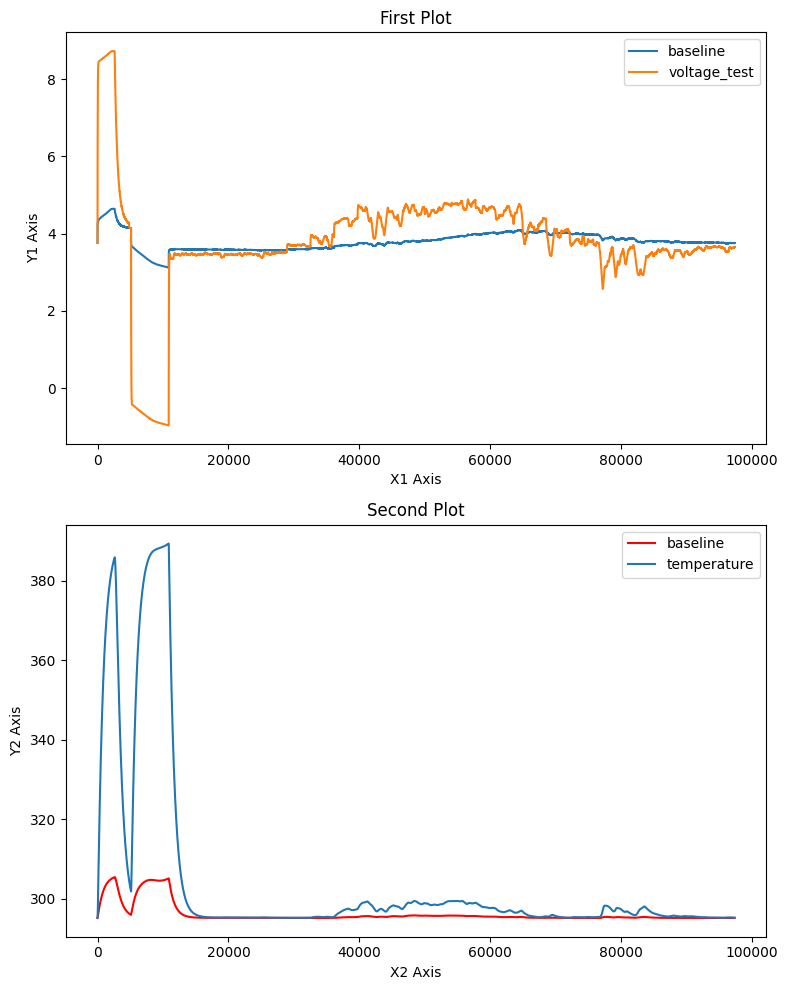

r0: 0.058, rc: 0.4, c: 8000000

8000000


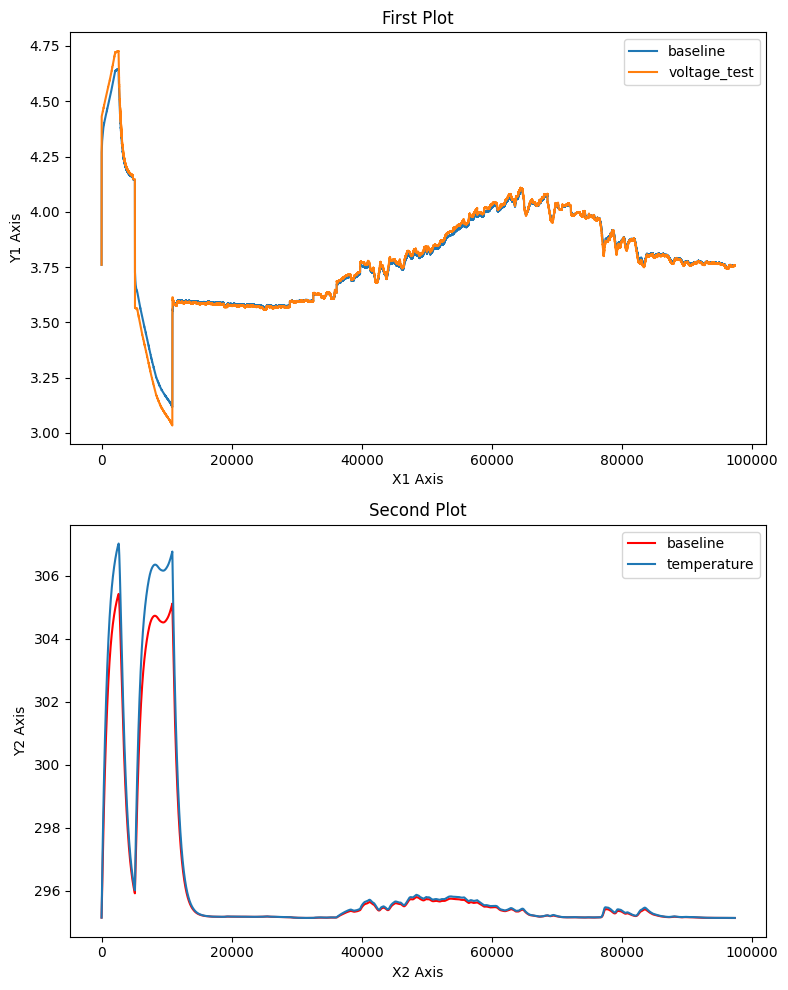

r0: 0.058, rc: 0.4, c: 9000000000000

9000000000000


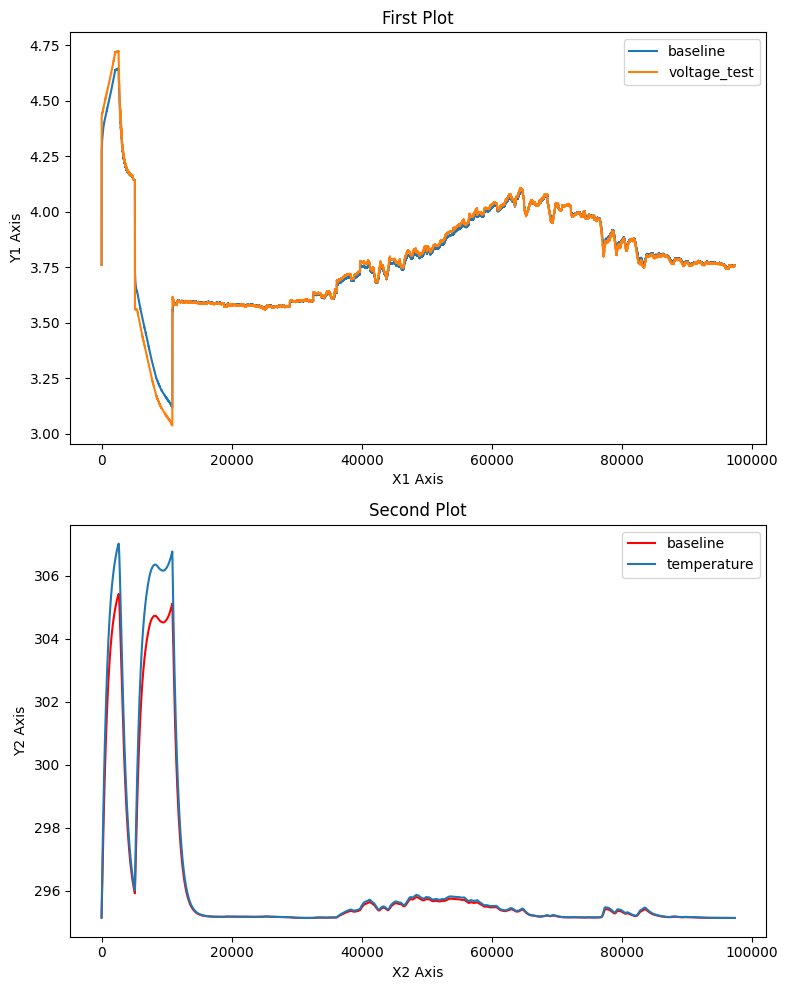

r0: 0.058, rc: 500, c: 72

72


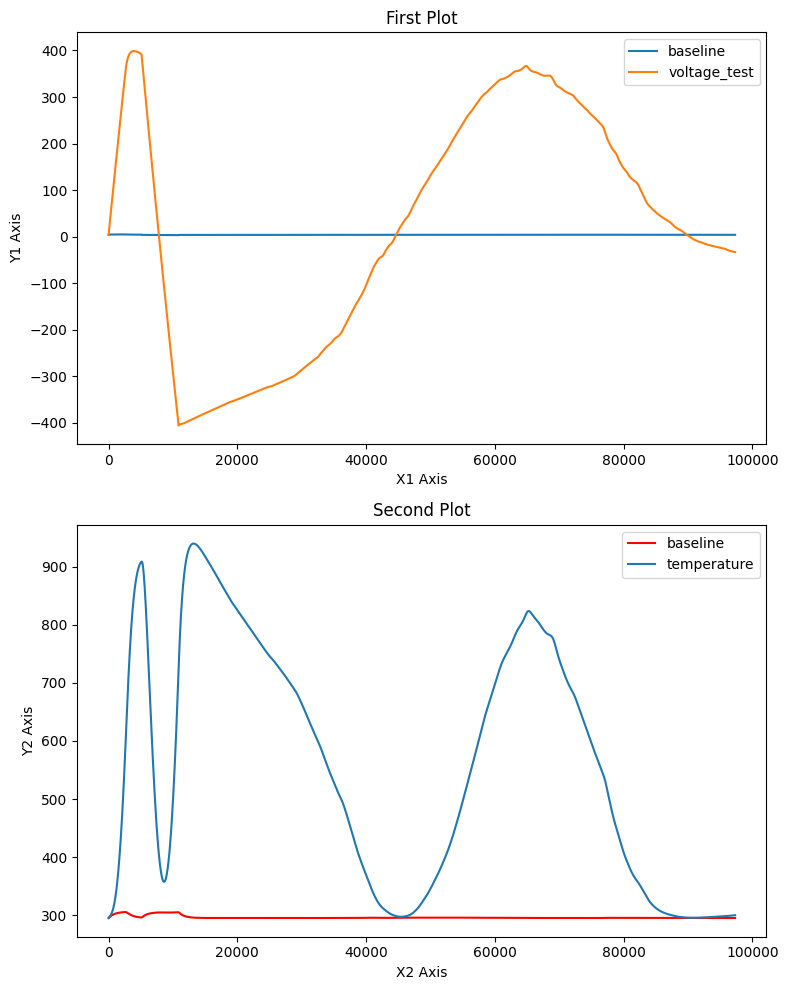

r0: 0.058, rc: 500, c: 8000000

8000000


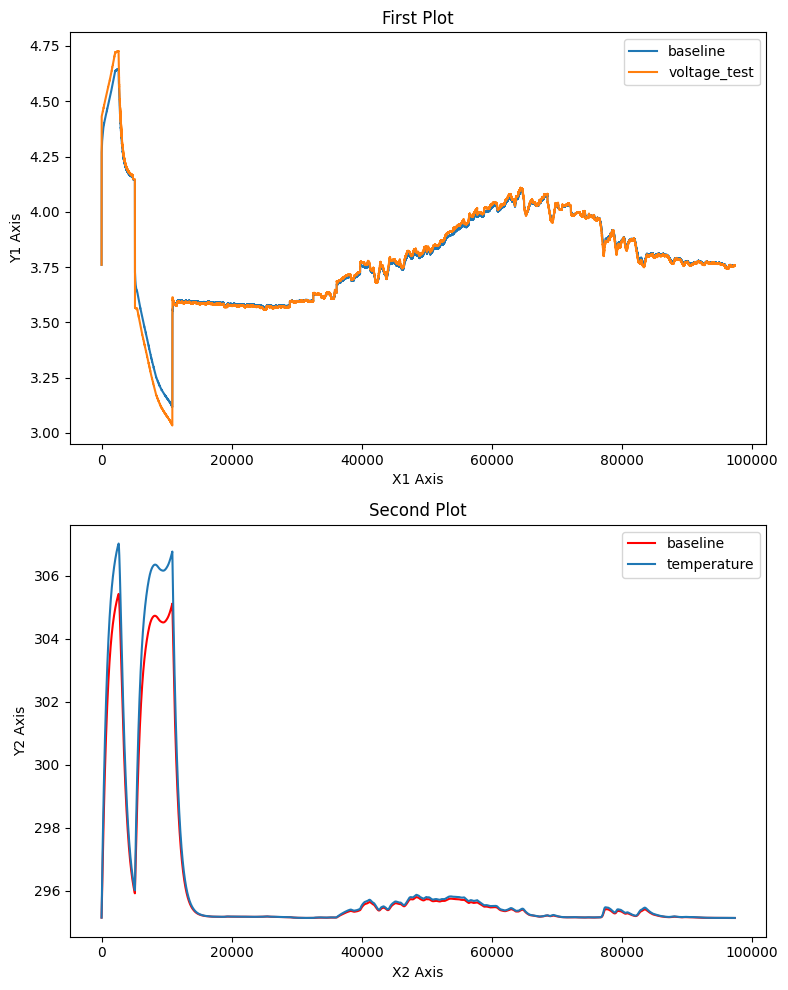

r0: 0.058, rc: 500, c: 9000000000000

9000000000000


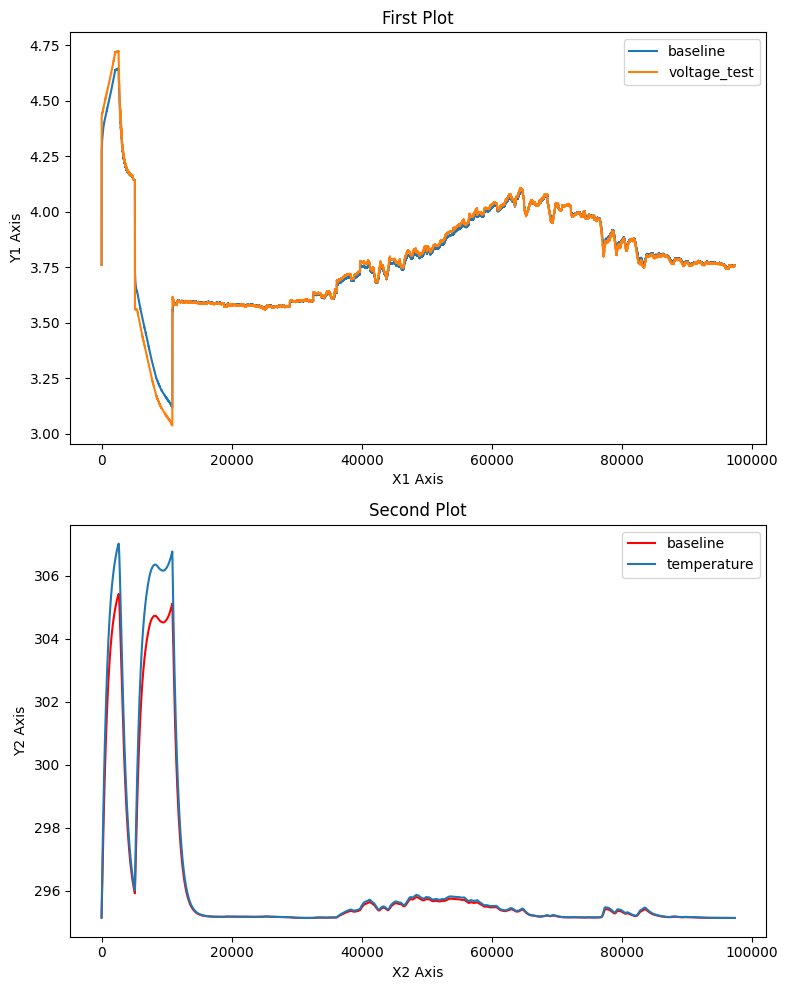

r0: 0.058, rc: 600000000, c: 72

72


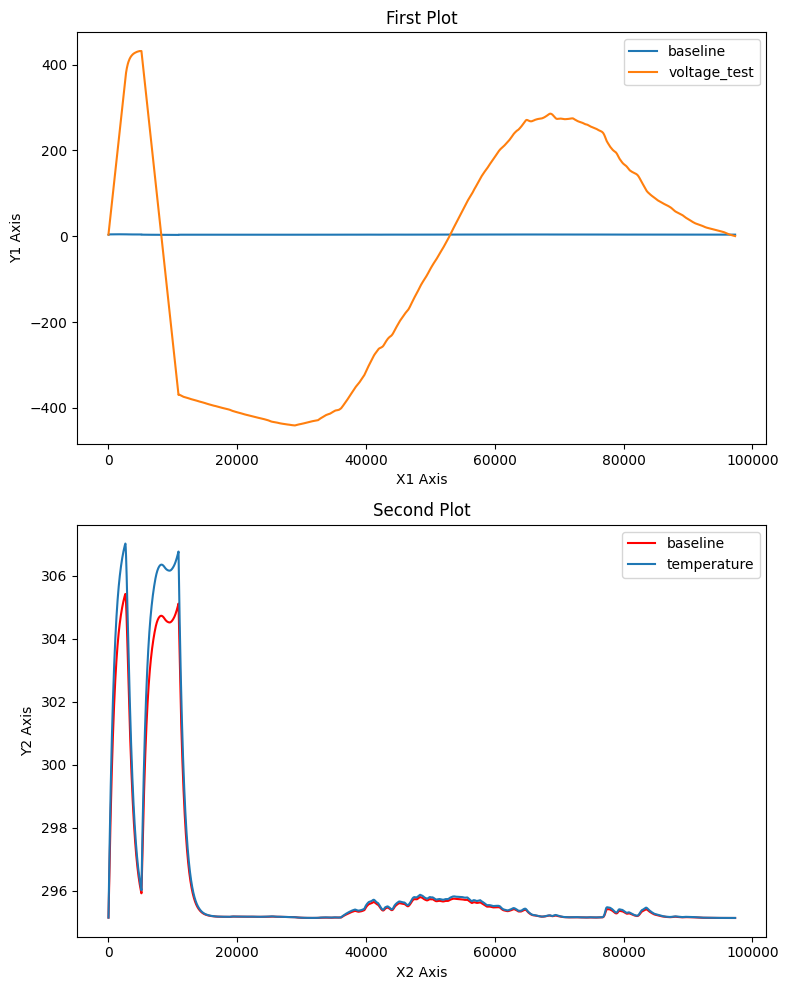

r0: 0.058, rc: 600000000, c: 8000000

8000000


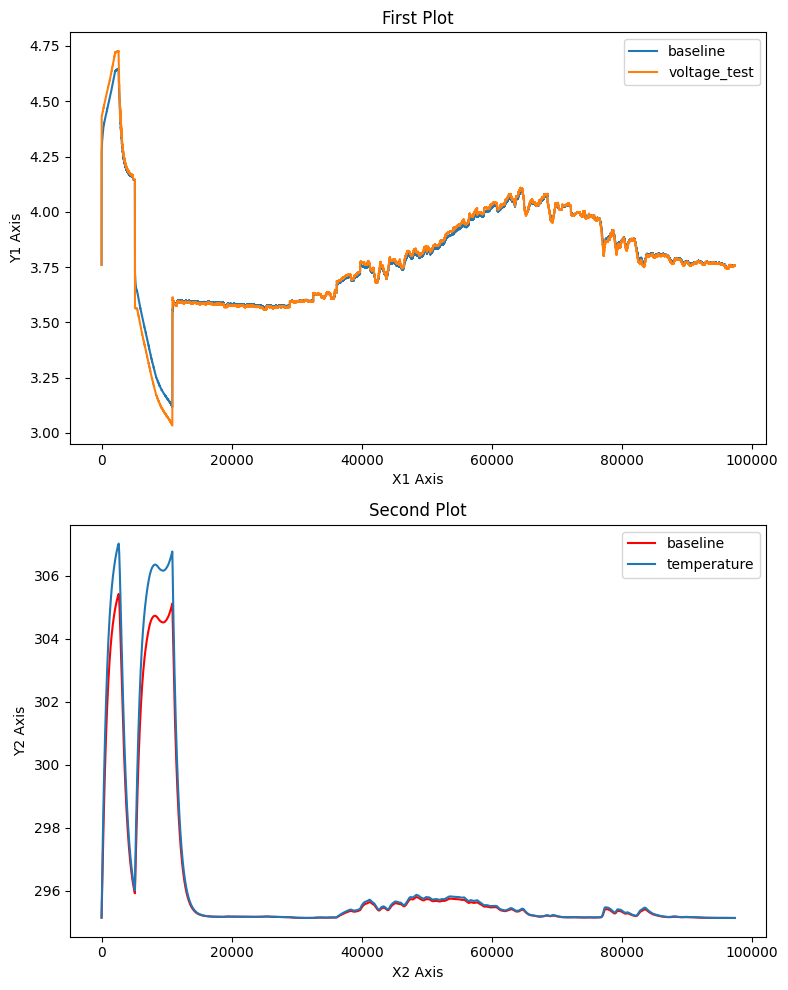

r0: 0.058, rc: 600000000, c: 9000000000000

9000000000000


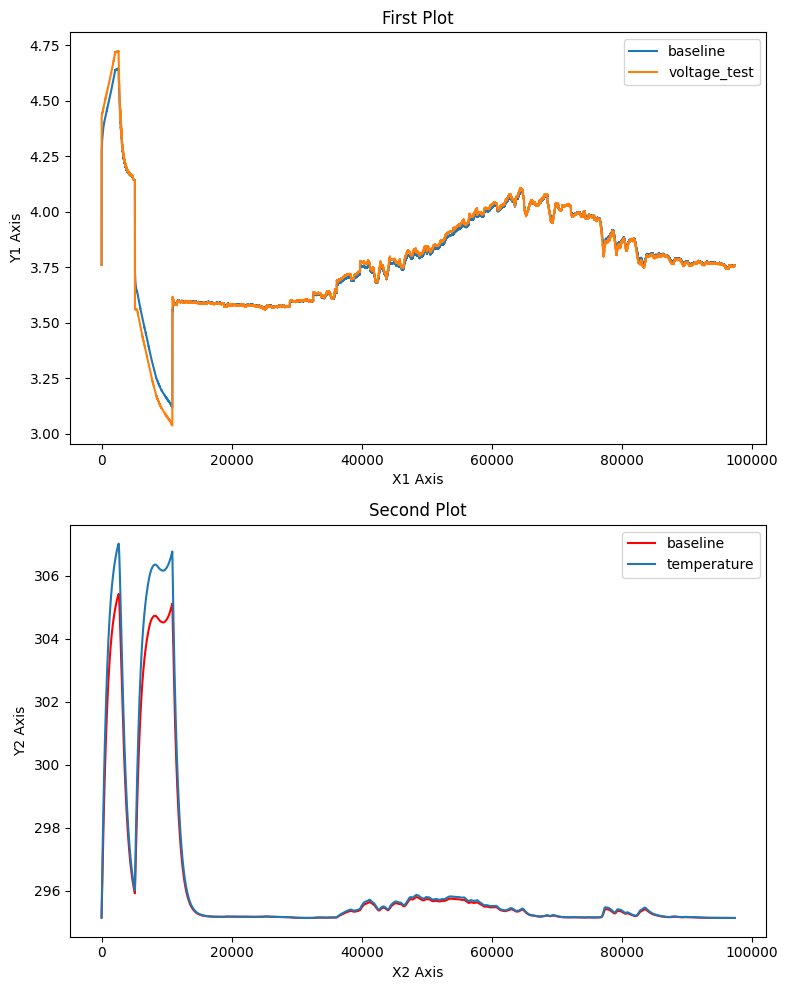

In [39]:
import itertools

r0 = [0.058]
rc = [0.4, 500, 600000000]
c = [72, 8000000, 9000000000000]

elapsed_time = 0
dt = 1   

combinations = list(itertools.product(r0, rc, c))

for combo in combinations:
    print(f"r0: {combo[0]}, rc: {combo[1]}, c: {combo[2]}")
    
    set_battery(battery=battery, reset_info=reset_info,theta=combo)
    
    for k, load in enumerate(i_real):
       elapsed_time += dt
       battery.t_series.append(elapsed_time)
       dt = df['time'].iloc[k] - df['time'].iloc[k - 1] if k > 0 else 1.0
       battery.step(load, dt, k)
       
    #results = battery.build_results_table()
    #voltage = baseline_results['operations']['voltage']
    voltage = battery._electrical_model.get_v_series()
    #temperature = baseline_results['operations']['temperature']
    temperature = battery._thermal_model.get_temp_series()
    
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
    
    # First subplot
    #print("voltage error:", np.array(voltage)-np.array(baseline_voltage))
    ax1.plot(baseline_voltage[0:len(voltage)], label='baseline')
    ax1.plot(voltage, label='voltage_test')
    ax1.set_xlabel('X1 Axis')
    ax1.set_ylabel('Y1 Axis')
    ax1.set_title('First Plot')
    ax1.legend()
    
    # Second subplot
    ax2.plot(baseline_temperature[0:len(temperature)], label='baseline', color='red')
    ax2.plot(temperature, label='temperature')
    ax2.set_xlabel('X2 Axis')
    ax2.set_ylabel('Y2 Axis')
    ax2.set_title('Second Plot')
    ax2.legend()
    
    # Display the plots
    plt.tight_layout()
    plt.show()   
